In [424]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_regression, make_classification
%matplotlib inline

In [425]:
# Make a synthetic dataset
X, y = make_classification()

# Make sure that the input and output data shapes are fine

def maybe_transform_Xy(X,y):
    # number of features has to be less than the number of data points
    # the assumption for further code is X.shape == (num_features, num_points)
    num_features, num_points = X.shape
    if num_features > num_points:
        X = X.T
    
    # y.shape == (1, num_points)
    if len(y.shape) != 2:
        y = y.reshape(1,-1)
    
    assert y.shape[1] == X.shape[1]
    
    return X,y

X, y = maybe_transform_Xy(X,y)
print(X.shape, y.shape)

(20, 100) (1, 100)


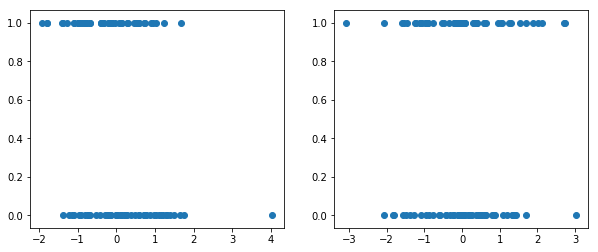

In [426]:
# Let's look at the data first
fig = plt.figure(figsize = (10,4))
ax = fig.add_subplot(1,2,1)
ax.scatter(X[0,:],y)
ax = fig.add_subplot(1,2,2)
ax.scatter(X[1,:],y)
plt.show()

# One layer artificial neural network for classification

### Notation

$x^{(i)}$ -- Input i, vector of shape (num_features,1)

$y^{(i)}$, $\hat{y}^{(i)}$ -- output i and predicted output i, vectors of shape (1,1)

$X$ -- Input, stacked $x^{(i)}$, matrix of shape (num_features, num_points)

$Y$ -- Expected output, stacked $y^{(i)}$, matrix of shape (1, num_points)

$\hat{Y}$ -- Model output, stacked $\hat{y}^{(i)}$, matrix of shape (1, num_points)

num_neurons -- size of the hidden layer, i.e. number of neurons

$W^{[1]}$ -- weights matrix of shape (num_features,num_neurons), hidden layer

$W^{[2]}$ -- weights matrix of shape (num_neurons, 1), output layer

$b^{[1]}$ -- b coefficient for the hidden layer

$b^{[2]}$ -- b coefficient for the output layer


### Forward propagation (vector notation)

$Z^{[1]} = W^{[1]T}X+b^{[1]}$

$A^{[1]} = \sigma(Z_1^{(i)})$

$Z^{[2]} = W^{[2]T}A^{[1]}+b^{[2]}$

$\hat{Y} = \sigma(Z^{[2]})$

### Loss function

$L(\hat{y}^{(i)}, y^{(i)}) = -y^{(i)} ln\left(\hat{y}^{(i)}\right)-\left(1-y^{(i)}\right)ln\left(1-\hat{y}^{(i)}\right)$

### Cost

$J = \frac{1}{m}\sum_{i=1}^m L(\hat{y}^{(i)}, y^{(i)})$

### Backward propagation

$d\hat{Y} = \frac{\partial L}{\partial \hat{Y}} = \frac{\hat{Y} - Y}{\hat{Y}\left(1-\hat{Y}\right)}$

$dZ^{[2]} = \frac{\partial L}{\partial Z^{[2]}} = \hat{Y} - Y$

$dW^{[2]} = \frac{\partial L}{\partial W^{[2]}} = dZ^{[2]} A^{[1]}$

$db^{[2]} = \frac{\partial L}{\partial b^{[2]}} = dZ^{[2]}$

$dA^{[1]} = \frac{\partial L}{\partial A^{[1]}} = dZ^{[2]} W^{[2]}$

$dZ^{[1]} = \frac{\partial L}{\partial Z^{[1]}} = dA^{[1]} A^{[1]}\left(1-A^{[1]}\right)$

$dW^{[1]} = \frac{\partial L}{\partial W^{[1]}} = dZ^{[1]} X$

$db^{[1]} = \frac{\partial L}{\partial b^{[1]}} = dZ^{[1]}$

### Update equations

$dW^{[j]} = \frac{1}{m} \sum_{i=1}^{m} dW^{[j](i)}$

$db^{[j]} = \frac{1}{m} \sum_{i=1}^{m} db^{[j](i)}$

$W^{[j]}_{t+1} = W^{[j]}_{t} - \alpha dW^{[j]}$

$b^{[j]}_{t+1} = b^{[j]}_{t} - \alpha db^{[j]}$

where $\alpha$ -- learning rate

In [427]:
# Initialize model parameters
# The weights for the ANN cannot be perfect zeros. If they are, all gradients are equal, 
# and so all the neurons will be equal. 
# To mitigate the problem, initialize the weights with random numbers. 
def initialize_randomly(n_features, n_neurons):
    W1 = np.random.normal(0,1.0,(n_features, n_neurons)) # Again, zero's will not work here, need to break the symmetry
    W2 = np.random.normal(0,1.0,(n_neurons, 1))
    b1 = 0
    b2 = 0
    params = {'W1':W1,'W2':W2,'b1':b1,'b2':b2}
    return params

params = initialize_randomly(2,5)
print(params)

{'b1': 0, 'b2': 0, 'W1': array([[ 0.37714056,  0.3691749 ,  0.24046046,  1.97629178, -0.80622809],
       [ 0.79610928,  1.34938186, -0.68217231, -0.68461312,  0.08332149]]), 'W2': array([[ 1.88801897],
       [ 1.46533584],
       [-1.19593253],
       [-0.75131797],
       [-0.30754209]])}


In [428]:
# Calculate sigmoid function
def sigmoid(x):
    return 1/(1+np.exp(-x))

x = np.arange(-10,10,1)
print(sigmoid(x))

[4.53978687e-05 1.23394576e-04 3.35350130e-04 9.11051194e-04
 2.47262316e-03 6.69285092e-03 1.79862100e-02 4.74258732e-02
 1.19202922e-01 2.68941421e-01 5.00000000e-01 7.31058579e-01
 8.80797078e-01 9.52574127e-01 9.82013790e-01 9.93307149e-01
 9.97527377e-01 9.99088949e-01 9.99664650e-01 9.99876605e-01]


In [429]:
# Do forward and backward propagation. params -- dictionary of model parameters
def propagate(params, X, y):
    # Forward propagation
    W1 = params['W1']
    W2 = params['W2']
    b1 = params['b1']
    b2 = params['b2']
    
    # The hidden layer
    z1 = np.dot(W1.T,X)+b1
    a1 = sigmoid(z1)
    
    # The output layer
    z2 = np.dot(W2.T,a1)+b2
    y_hat = sigmoid(z2)
    
    losses = -(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))
    cost = np.mean(losses)
    
    # Backward propagation
    dz2 = y_hat-y
    dW2 = np.dot(a1,dz2.T)
    db2 = np.mean(dz2)
    da1 = np.dot(W2,(y_hat-y))
    dz1 = da1*a1*(1-a1)
    dW1 = np.dot(X,dz1.T)
    db1 = np.mean(dz1)

    grads = {'dW1':dW1,'db1':db1, 'dW2':dW2,'db2':db2}
    return grads, cost

params = initialize_randomly(X.shape[0], n_neurons = 5)
grads,cost = propagate(params,X,y)
#print(grads, cost)

In [430]:
# Apply gradient descent to find model parameters 

def optimize(params,X,y,num_iterations, learning_rate, print_cost = False):
    costs = []
    W1, b1 = params['W1'], params['b1']
    W2, b2 = params['W2'], params['b2'] 
    
    for i in range(num_iterations):
        grads, cost = propagate(params,X,y)
        dW1, db1 = grads['dW1'], grads['db1']
        dW2, db2 = grads['dW2'], grads['db2']        
        
        W1 = W1 - learning_rate*dW1
        b1 = b1 - learning_rate*db1
        W2 = W2 - learning_rate*dW2
        b2 = b2 - learning_rate*db2
        
        params = {'W1':W1,'W2':W2,'b1':b1,'b2':b2}
        
        costs.append(cost)
        
        if print_cost and i%10 == 0:
            print("Cost after iteration %d: %.4f"%(i,cost))
            
    params = {'W1':W1,'b1':b1,'W2':W2,'b2':b2}
    grads = {'dW1':dW1,'db1':db1,'dW2':dW2,'db2':db2}
        
    return params, grads, costs


params = initialize_randomly(X.shape[0], n_neurons = 5)
params, grads, costs = optimize(params,X,y,num_iterations = 100, learning_rate = 0.1, print_cost = True)


Cost after iteration 0: 0.7362
Cost after iteration 10: 0.1883
Cost after iteration 20: 0.0824
Cost after iteration 30: 0.0541
Cost after iteration 40: 0.0438
Cost after iteration 50: 0.0378
Cost after iteration 60: 0.0338
Cost after iteration 70: 0.0309
Cost after iteration 80: 0.0288
Cost after iteration 90: 0.0271


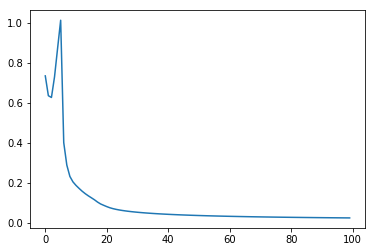

In [431]:
# Let's see how the cost function is decreasing
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(costs)
plt.show()

In [432]:
# Predict
def predict(params,X,discrete = True):
    m = X.shape[0]
    W1 = params['W1']
    W2 = params['W2']
    b1 = params['b1']
    b2 = params['b2']
    
    # The hidden layer
    z1 = np.dot(W1.T,X)+b1
    a1 = sigmoid(z1)
    
    # The output layer
    z2 = np.dot(W2.T,a1)+b2
    y_hat = sigmoid(z2)
    if discrete:
        y_hat = np.round(y_hat)
    return y_hat
    
params = initialize_randomly(X.shape[0], n_neurons = 5)
params, grads, costs = optimize(params,X,y,num_iterations = 100, learning_rate = 0.1, print_cost = False)
y_pred = predict(params,X)
print(y_pred)

[[1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0.
  0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.
  0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.
  0. 1. 0. 1.]]


In [433]:
# Artificial Neural Network

def model(X_train, y_train, X_test, y_test, n_neurons = 5, num_iterations = 100, learning_rate = 0.1, print_cost = False):
    
    assert X_train.shape[0] == X_test.shape[0] and X_train.shape[1] == y_train.shape[1]
    assert X_test.shape[1] == y_test.shape[1] and y_train.shape[0] == 1 and y_test.shape[0] == 1
    
    num_features = X_train.shape[0]
    params = initialize_randomly(X.shape[0], n_neurons)
    
    params, grads, costs = optimize(params,X_train,y_train,num_iterations, learning_rate, print_cost)
    
    y_pred_test = predict(params,X_test)
    y_pred_train = predict(params,X_train)
    y_pred_test_prob = predict(params,X_test,discrete = False)

    print("Train accuracy: %.4f%%" % (100-np.mean(np.abs(y_pred_train-y_train))*100))
    print("Test accuracy: %.4f%%" % (100-np.mean(np.abs(y_pred_test-y_test))*100))
    
    d = {'costs': costs,
        'y_pred_test':y_pred_test,
        'y_pred_train':y_pred_train,
        'y_pred_test_prob':y_pred_test_prob,
        'params':params,
        #'w':W, 'b':b,
        'learning_rate':learning_rate,'num_iterations':num_iterations}
    return d
    
X_train, X_test = X[:,:70],X[:,70:] 
y_train, y_test = y[:,:70],y[:,70:] 
d = model(X_train,y_train,X_test,y_test, num_iterations = 1000, n_neurons = 50, learning_rate = 0.01, 
          print_cost = False)

Train accuracy: 100.0000%
Test accuracy: 90.0000%


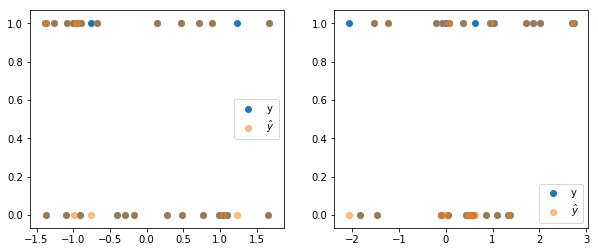

In [434]:
# Let's see how the model is doing on test data
y_pred_test = d['y_pred_test']

fig = plt.figure(figsize = (10,4))
ax = fig.add_subplot(1,2,1)
ax.scatter(X_test[0,:],y_test, label = 'y')
ax.scatter(X_test[0,:],y_pred_test, label = '$\hat{y}$',alpha = 0.5)
ax.legend()
ax = fig.add_subplot(1,2,2)
ax.scatter(X_test[1,:],y_test, label = 'y')
ax.scatter(X_test[1,:],y_pred_test, label = '$\hat{y}$', alpha = 0.5)
ax.legend()
plt.show()

## Testing artificial neural network on boolean functions

In [436]:
X = np.asarray([[0,0],[0,1],[1,0],[1,1]])
y = np.asarray([0,1,1,0])

X, y = maybe_transform_Xy(X,y)
print(X.shape,y.shape)

(2, 4) (1, 4)


Cost after iteration 0: 2.4919
Cost after iteration 10: 2.9683
Cost after iteration 20: 3.1760
Cost after iteration 30: 3.0910
Cost after iteration 40: 2.9908
Cost after iteration 50: 2.8731
Cost after iteration 60: 2.7297
Cost after iteration 70: 2.5574
Cost after iteration 80: 2.3592
Cost after iteration 90: 2.1433
Cost after iteration 100: 1.9183
Cost after iteration 110: 1.6900
Cost after iteration 120: 1.4591
Cost after iteration 130: 1.2202
Cost after iteration 140: 0.9441
Cost after iteration 150: 0.1475
Cost after iteration 160: 0.0310
Cost after iteration 170: 0.0304
Cost after iteration 180: 0.0298
Cost after iteration 190: 0.0293
Cost after iteration 200: 0.0288
Cost after iteration 210: 0.0284
Cost after iteration 220: 0.0279
Cost after iteration 230: 0.0275
Cost after iteration 240: 0.0271
Cost after iteration 250: 0.0267
Cost after iteration 260: 0.0263
Cost after iteration 270: 0.0259
Cost after iteration 280: 0.0256
Cost after iteration 290: 0.0252
Cost after iteration 

Cost after iteration 2460: 0.0062
Cost after iteration 2470: 0.0061
Cost after iteration 2480: 0.0061
Cost after iteration 2490: 0.0061
Cost after iteration 2500: 0.0061
Cost after iteration 2510: 0.0061
Cost after iteration 2520: 0.0060
Cost after iteration 2530: 0.0060
Cost after iteration 2540: 0.0060
Cost after iteration 2550: 0.0060
Cost after iteration 2560: 0.0059
Cost after iteration 2570: 0.0059
Cost after iteration 2580: 0.0059
Cost after iteration 2590: 0.0059
Cost after iteration 2600: 0.0059
Cost after iteration 2610: 0.0058
Cost after iteration 2620: 0.0058
Cost after iteration 2630: 0.0058
Cost after iteration 2640: 0.0058
Cost after iteration 2650: 0.0058
Cost after iteration 2660: 0.0058
Cost after iteration 2670: 0.0057
Cost after iteration 2680: 0.0057
Cost after iteration 2690: 0.0057
Cost after iteration 2700: 0.0057
Cost after iteration 2710: 0.0057
Cost after iteration 2720: 0.0056
Cost after iteration 2730: 0.0056
Cost after iteration 2740: 0.0056
Cost after ite

Cost after iteration 4920: 0.0033
Cost after iteration 4930: 0.0033
Cost after iteration 4940: 0.0033
Cost after iteration 4950: 0.0033
Cost after iteration 4960: 0.0033
Cost after iteration 4970: 0.0033
Cost after iteration 4980: 0.0033
Cost after iteration 4990: 0.0033
Cost after iteration 5000: 0.0032
Cost after iteration 5010: 0.0032
Cost after iteration 5020: 0.0032
Cost after iteration 5030: 0.0032
Cost after iteration 5040: 0.0032
Cost after iteration 5050: 0.0032
Cost after iteration 5060: 0.0032
Cost after iteration 5070: 0.0032
Cost after iteration 5080: 0.0032
Cost after iteration 5090: 0.0032
Cost after iteration 5100: 0.0032
Cost after iteration 5110: 0.0032
Cost after iteration 5120: 0.0032
Cost after iteration 5130: 0.0032
Cost after iteration 5140: 0.0032
Cost after iteration 5150: 0.0032
Cost after iteration 5160: 0.0032
Cost after iteration 5170: 0.0031
Cost after iteration 5180: 0.0031
Cost after iteration 5190: 0.0031
Cost after iteration 5200: 0.0031
Cost after ite

Cost after iteration 7420: 0.0022
Cost after iteration 7430: 0.0022
Cost after iteration 7440: 0.0022
Cost after iteration 7450: 0.0022
Cost after iteration 7460: 0.0022
Cost after iteration 7470: 0.0022
Cost after iteration 7480: 0.0022
Cost after iteration 7490: 0.0022
Cost after iteration 7500: 0.0022
Cost after iteration 7510: 0.0022
Cost after iteration 7520: 0.0022
Cost after iteration 7530: 0.0022
Cost after iteration 7540: 0.0022
Cost after iteration 7550: 0.0022
Cost after iteration 7560: 0.0022
Cost after iteration 7570: 0.0022
Cost after iteration 7580: 0.0022
Cost after iteration 7590: 0.0022
Cost after iteration 7600: 0.0022
Cost after iteration 7610: 0.0022
Cost after iteration 7620: 0.0022
Cost after iteration 7630: 0.0022
Cost after iteration 7640: 0.0022
Cost after iteration 7650: 0.0022
Cost after iteration 7660: 0.0022
Cost after iteration 7670: 0.0022
Cost after iteration 7680: 0.0022
Cost after iteration 7690: 0.0022
Cost after iteration 7700: 0.0022
Cost after ite

Cost after iteration 10020: 0.0017
Cost after iteration 10030: 0.0017
Cost after iteration 10040: 0.0017
Cost after iteration 10050: 0.0017
Cost after iteration 10060: 0.0017
Cost after iteration 10070: 0.0017
Cost after iteration 10080: 0.0017
Cost after iteration 10090: 0.0017
Cost after iteration 10100: 0.0017
Cost after iteration 10110: 0.0017
Cost after iteration 10120: 0.0017
Cost after iteration 10130: 0.0017
Cost after iteration 10140: 0.0017
Cost after iteration 10150: 0.0017
Cost after iteration 10160: 0.0016
Cost after iteration 10170: 0.0016
Cost after iteration 10180: 0.0016
Cost after iteration 10190: 0.0016
Cost after iteration 10200: 0.0016
Cost after iteration 10210: 0.0016
Cost after iteration 10220: 0.0016
Cost after iteration 10230: 0.0016
Cost after iteration 10240: 0.0016
Cost after iteration 10250: 0.0016
Cost after iteration 10260: 0.0016
Cost after iteration 10270: 0.0016
Cost after iteration 10280: 0.0016
Cost after iteration 10290: 0.0016
Cost after iteration

Cost after iteration 12520: 0.0013
Cost after iteration 12530: 0.0013
Cost after iteration 12540: 0.0013
Cost after iteration 12550: 0.0013
Cost after iteration 12560: 0.0013
Cost after iteration 12570: 0.0013
Cost after iteration 12580: 0.0013
Cost after iteration 12590: 0.0013
Cost after iteration 12600: 0.0013
Cost after iteration 12610: 0.0013
Cost after iteration 12620: 0.0013
Cost after iteration 12630: 0.0013
Cost after iteration 12640: 0.0013
Cost after iteration 12650: 0.0013
Cost after iteration 12660: 0.0013
Cost after iteration 12670: 0.0013
Cost after iteration 12680: 0.0013
Cost after iteration 12690: 0.0013
Cost after iteration 12700: 0.0013
Cost after iteration 12710: 0.0013
Cost after iteration 12720: 0.0013
Cost after iteration 12730: 0.0013
Cost after iteration 12740: 0.0013
Cost after iteration 12750: 0.0013
Cost after iteration 12760: 0.0013
Cost after iteration 12770: 0.0013
Cost after iteration 12780: 0.0013
Cost after iteration 12790: 0.0013
Cost after iteration

Cost after iteration 14920: 0.0011
Cost after iteration 14930: 0.0011
Cost after iteration 14940: 0.0011
Cost after iteration 14950: 0.0011
Cost after iteration 14960: 0.0011
Cost after iteration 14970: 0.0011
Cost after iteration 14980: 0.0011
Cost after iteration 14990: 0.0011
Cost after iteration 15000: 0.0011
Cost after iteration 15010: 0.0011
Cost after iteration 15020: 0.0011
Cost after iteration 15030: 0.0011
Cost after iteration 15040: 0.0011
Cost after iteration 15050: 0.0011
Cost after iteration 15060: 0.0011
Cost after iteration 15070: 0.0011
Cost after iteration 15080: 0.0011
Cost after iteration 15090: 0.0011
Cost after iteration 15100: 0.0011
Cost after iteration 15110: 0.0011
Cost after iteration 15120: 0.0011
Cost after iteration 15130: 0.0011
Cost after iteration 15140: 0.0011
Cost after iteration 15150: 0.0011
Cost after iteration 15160: 0.0011
Cost after iteration 15170: 0.0011
Cost after iteration 15180: 0.0011
Cost after iteration 15190: 0.0011
Cost after iteration

Cost after iteration 17410: 0.0010
Cost after iteration 17420: 0.0010
Cost after iteration 17430: 0.0010
Cost after iteration 17440: 0.0010
Cost after iteration 17450: 0.0010
Cost after iteration 17460: 0.0010
Cost after iteration 17470: 0.0010
Cost after iteration 17480: 0.0010
Cost after iteration 17490: 0.0010
Cost after iteration 17500: 0.0010
Cost after iteration 17510: 0.0010
Cost after iteration 17520: 0.0010
Cost after iteration 17530: 0.0010
Cost after iteration 17540: 0.0010
Cost after iteration 17550: 0.0010
Cost after iteration 17560: 0.0010
Cost after iteration 17570: 0.0010
Cost after iteration 17580: 0.0010
Cost after iteration 17590: 0.0010
Cost after iteration 17600: 0.0010
Cost after iteration 17610: 0.0010
Cost after iteration 17620: 0.0010
Cost after iteration 17630: 0.0010
Cost after iteration 17640: 0.0010
Cost after iteration 17650: 0.0010
Cost after iteration 17660: 0.0010
Cost after iteration 17670: 0.0010
Cost after iteration 17680: 0.0010
Cost after iteration

Cost after iteration 19860: 0.0009
Cost after iteration 19870: 0.0009
Cost after iteration 19880: 0.0009
Cost after iteration 19890: 0.0009
Cost after iteration 19900: 0.0009
Cost after iteration 19910: 0.0009
Cost after iteration 19920: 0.0009
Cost after iteration 19930: 0.0009
Cost after iteration 19940: 0.0009
Cost after iteration 19950: 0.0008
Cost after iteration 19960: 0.0008
Cost after iteration 19970: 0.0008
Cost after iteration 19980: 0.0008
Cost after iteration 19990: 0.0008
Train accuracy: 100.0000%
Test accuracy: 100.0000%
[[0. 1. 1. 0.]]


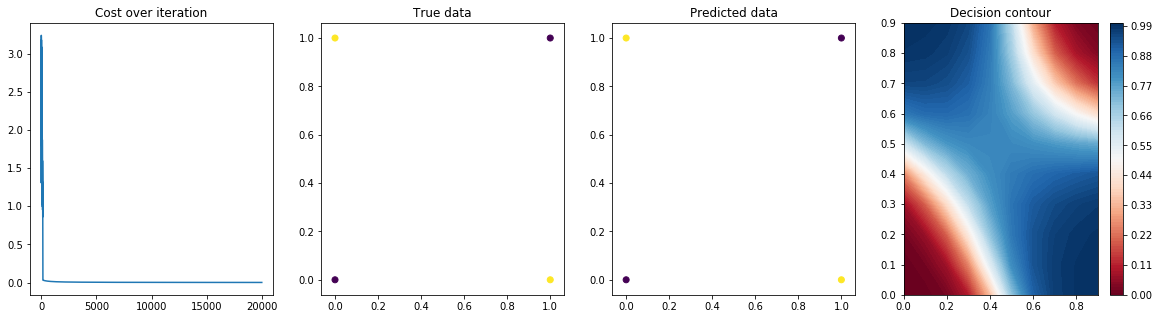

In [442]:
d = model(X,y,X,y, num_iterations = 20000, n_neurons = 2000, learning_rate = 0.01, 
          print_cost = True)
print(d['y_pred_test'])

# Let's see how the cost function is decreasing
fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,4,1)
ax.plot(d['costs'])
ax.set_title('Cost over iteration')

ax = fig.add_subplot(1,4,2)
ax.scatter(X[0,:],X[1,:],c = y)
ax.set_title('True data')

ax = fig.add_subplot(1,4,3)
ax.scatter(X[0,:],X[1,:],c = d['y_pred_test'])
ax.set_title('Predicted data')

x1, x2 = np.mgrid[0:1:0.1, 0:1:0.1]
X_sim = np.c_[x1.ravel(),x2.ravel()].T
y_contour = predict(d['params'],X_sim,discrete = False).reshape(x1.shape[0],-1)

ax = fig.add_subplot(1,4,4)
c = ax.contourf(x1,x2,y_contour,100,cmap='RdBu')
ax.set_title('Decision contour')
fig.colorbar(c)

plt.show()

## Artificial Neural Networks with Tensorflow

In [368]:
import tensorflow as tf

In [369]:
def create_placeholders(n_features):
    X = tf.placeholder(tf.float32, [n_features, None], name = 'X')
    y = tf.placeholder(tf.float32, [1, None], name = 'y')
    return X,y

tf.reset_default_graph()
X_tensor, y_tensor = create_placeholders(X.shape[0])
print(X_tensor, y_tensor)

Tensor("X:0", shape=(2, ?), dtype=float32) Tensor("y:0", shape=(1, ?), dtype=float32)


In [370]:
def initialize_parameters(n_features, num_neurons):
    W1 = tf.get_variable("W1", [n_features, num_neurons], initializer = tf.truncated_normal_initializer(), dtype = tf.float32)
    b1 = tf.get_variable("b1", [1], initializer = tf.zeros_initializer(), dtype = tf.float32)
    W2 = tf.get_variable("W2", [num_neurons, 1], initializer = tf.truncated_normal_initializer(), dtype = tf.float32)
    b2 = tf.get_variable("b2", [1], initializer = tf.zeros_initializer(), dtype = tf.float32)
    
    parameters = {'W1':W1,'b1':b1,'W2':W2,'b2':b2}
    return parameters

tf.reset_default_graph()
parameters = initialize_parameters(X.shape[0],num_neurons = 10)
print(parameters)

{'b1': <tf.Variable 'b1:0' shape=(1,) dtype=float32_ref>, 'b2': <tf.Variable 'b2:0' shape=(1,) dtype=float32_ref>, 'W1': <tf.Variable 'W1:0' shape=(2, 10) dtype=float32_ref>, 'W2': <tf.Variable 'W2:0' shape=(10, 1) dtype=float32_ref>}


In [371]:
def forward_propagation(X_tensor, parameters):
    W1, b1 = parameters['W1'], parameters['b1']
    W2, b2 = parameters['W2'], parameters['b2']    
    z1 = tf.matmul(tf.transpose(W1),X_tensor)+b1
    a1 = 1/(1+tf.exp(-z1))
    z2 = tf.matmul(tf.transpose(W2),a1)+b2
    a2 = 1/(1+tf.exp(-z2))
    return a2

tf.reset_default_graph()
with tf.Session() as sess:
    X_tensor, y_tensor = create_placeholders(2)
    parameters = initialize_parameters(2,num_neurons = 5)
    y_hat = forward_propagation(X_tensor, parameters)
    print("y_hat = %s" %str(y_hat))

y_hat = Tensor("truediv_1:0", shape=(1, ?), dtype=float32)


In [372]:
def compute_cost(y_hat_tensor, y_tensor):
    losses = tf.multiply(y_tensor,tf.log(y_hat_tensor))+tf.multiply(1-y_tensor,tf.log(1-y_hat_tensor))
    return tf.reduce_mean(-losses)

tf.reset_default_graph()

with tf.Session() as sess:
    X_tensor, y_tensor = create_placeholders(2)
    parameters = initialize_parameters(2, num_neurons = 5)
    y_hat_tensor = forward_propagation(X_tensor, parameters)
    cost = compute_cost(y_hat_tensor, y_tensor)
    print("cost = %s" %str(cost))

cost = Tensor("Mean:0", shape=(), dtype=float32)


In [373]:
def compute_accuracy(y_hat_tensor, y_tensor):
    matches = tf.equal(tf.round(y_hat_tensor),y_tensor)
    accuracy = tf.reduce_mean(tf.cast(matches,dtype = tf.float32))*100
    return accuracy

tf.reset_default_graph()

with tf.Session() as sess:
    X_tensor, y_tensor = create_placeholders(2)
    parameters = initialize_parameters(2, num_neurons = 5)
    y_hat_tensor = forward_propagation(X_tensor, parameters)
    accuracy = compute_accuracy(y_hat_tensor, y_tensor)
    print("accuracy = %s" %str(accuracy))

accuracy = Tensor("mul:0", shape=(), dtype=float32)


In [374]:
def model(X_train, y_train, X_test, y_test, num_iterations = 100, num_neurons = 5, learning_rate = 0.1, print_cost = False,
         show_plot = True):
    
    tf.reset_default_graph()
    n_features, n_x = X_train.shape
    n_y = y_train.shape[0]
    
    X_tensor, y_tensor = create_placeholders(n_features)
    parameters = initialize_parameters(n_features, num_neurons)
    y_hat_tensor = forward_propagation(X_tensor, parameters)
    cost = compute_cost(y_hat_tensor, y_tensor)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
    accuracy = compute_accuracy(y_hat_tensor, y_tensor)
    
    init = tf.global_variables_initializer()
    
    costs = []
    with tf.Session() as sess:
        sess.run(init)
        for i in range(num_iterations):
            _, c = sess.run([optimizer,cost],feed_dict={
                X_tensor:X_train, y_tensor:y_train
            })
            costs.append(c)
            if print_cost and i % 100 == 0:
                print("Iteration %d, cost: %.3f" %(i,c))
        if show_plot:
            fig = plt.figure()
            ax = fig.add_subplot(1,1,1)
            ax.plot(np.squeeze(costs))
            ax.set_xlabel('Iteration')
            ax.set_ylabel('Cost')
            plt.show()

        parameters = sess.run(parameters)
        
        acc_train = accuracy.eval({X_tensor:X_train, y_tensor:y_train})
        print("Train accuracy: %.2f%%"%acc_train)
        
        acc_test = accuracy.eval({X_tensor:X_test, y_tensor:y_test})
        print("Test accuracy: %.2f%%"%acc_test)
        
        y_pred_test = y_tensor.eval({X_tensor:X_test, y_tensor:y_test})
        y_pred_train = y_tensor.eval({X_tensor:X_train, y_tensor:y_train})
        
        d = {'costs': costs, 'y_pred_test':y_pred_test,'y_pred_train':y_pred_train,
             'params':params,'learning_rate':learning_rate,'num_iterations':num_iterations}
        
        return d
    


(2, 9) (1, 9)


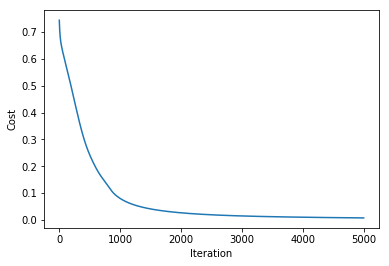

Train accuracy: 100.00%
Test accuracy: 86.67%


In [375]:
#X = np.asarray([[0,0],[0,1],[1,0],[1,1],[0.5,0.5]])
X = np.asarray([[0,0],[0,0.5],[0,1.0],
               [0.5,0],[0.5,0.5],[0.5,1.0],
               [1.0,0],[1.0,0.5],[1.0,1.0]])
y = np.asarray([1,0,1,0,1,0,1,0,1])

X, y = maybe_transform_Xy(X,y)
print(X.shape,y.shape)

parameters = model(X_train,y_train,X_test,y_test, num_iterations = 5000, print_cost = False, show_plot = True)